In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-10-31 15:35:53.995828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 15:35:54.001389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 15:35:54.001901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps according to the reference paper

In [15]:
def trainPreprocessA(img, lab):
        
        img = tf.image.random_crop(img, [CROP_HEIGHT, CROP_WIDTH, 3])
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        img = tf.clip_by_value(img, 0.0, 255.0)
        
        return img, lab

In [16]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [17]:
def extractGenderLabel(img, lab):
    
    lab = lab['gender']
    
    return img, lab

In [18]:
def extractAgeLabel(img, lab):
    
    lab = lab['age']
    
    return img, lab

### Generate Folds for K-Folds validation

In [19]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [20]:
trainPreBatch = [("train_process_a", trainPreprocessA), 
                 ("train_extract_gender", extractGenderLabel)]

valPreBatch = [("val_process_a", valPreprocessA), 
               ("val_extract_gender", extractGenderLabel)]

In [21]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-10-31 15:35:54.261482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 15:35:54.262277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 15:35:54.262648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 15:35:54.262945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
len(folds)

5

### Check data

In [23]:
for x,y in folds[0][0].take(1):
    pass

In [24]:
x

<tf.Tensor: shape=(4, 227, 227, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.89931870e+01, 0.00000000e+00, 0.00000000e+00],
         [5.78469696e+01, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0

In [25]:
y

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

<IPython.core.display.Javascript object>


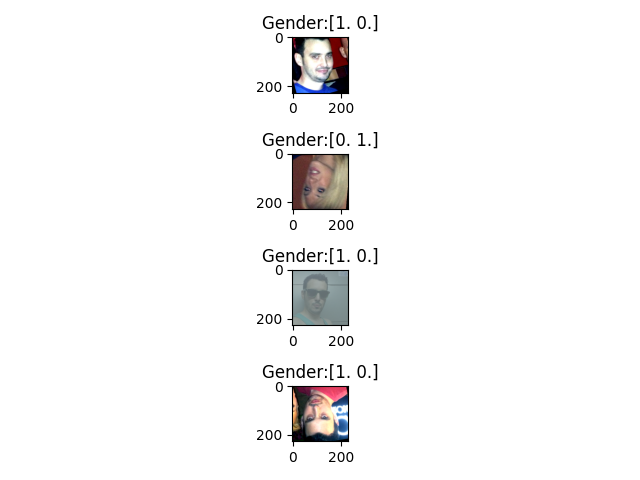

In [26]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y[i]}")
        
plt.tight_layout()

### Model

In [27]:
def createModel():
    inp = tf.keras.Input(shape=(CROP_HEIGHT, CROP_WIDTH, 3))

    backbone = tf.keras.applications.efficientnet_v2.EfficientNetV2M(include_top=False, input_shape=(CROP_HEIGHT, CROP_WIDTH, 3))
    backbone.trainable = False    
    
    flat1 = tf.keras.layers.Flatten(name='flat1')
    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='fc2')

    o = tf.keras.applications.efficientnet_v2.preprocess_inputtNetV2-L 85.7% 120M 53B 98 24
EfficientNetV2-S (21k) 84.9% 22M 8.8B 24 9.0
EfficientNetV(inp)
    o = backbone(o, training=False)
    o = flat1(o)
    o = fc1(o)
    o = do1(o)

    o = fc2(o)

    model = tf.keras.models.Model(inputs=inp, outputs=o, name='baseline_1')
    
    return model

In [28]:
model = createModel()

In [29]:
model.summary()

Model: "baseline_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 8, 8, 1280)       53150388  
 l)                                                              
                                                                 
 flat1 (Flatten)             (None, 81920)             0         
                                                                 
 fc1 (Dense)                 (None, 128)               10485888  
                                                                 
 do1 (Dropout)               (None, 128)               0         
                                                                 
 fc2 (Dense)                 (None, 2)                 258       
                                                        

### Compile Model

In [30]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [31]:
def schedule(epoch, lr):
    return lr

In [32]:
logBasePath = "log/efficientnet_1"
logPrefix = "log"

In [33]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-10-31 15:36:04.577284: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-31 15:36:04.577304: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-10-31 15:36:04.577324: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-10-31 15:36:04.660260: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-31 15:36:04.661485: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-31 15:36:08.073805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


   8/3528 [..............................] - ETA: 1:31 - loss: 0.7577 - accuracy: 0.5000

2022-10-31 15:36:09.156704: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 82s 22ms/step - loss: 0.7561 - accuracy: 0.5027
Epoch 1/300
   1/1000 [..............................] - ETA: 2:08:04 - loss: 1.0295 - accuracy: 0.2500

2022-10-31 15:37:34.671246: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-31 15:37:34.671270: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 1:21 - loss: 0.7776 - accuracy: 0.5625

2022-10-31 15:37:35.305522: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 15:37:35.306703: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-31 15:37:35.393152: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 13128 callback api events and 13103 activity events. 
2022-10-31 15:37:35.497376: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-31 15:37:35.607090: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35

2022-10-31 15:37:35.713705: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35/rachanon-pc1.trace.json.gz


  14/1000 [..............................] - ETA: 1:39 - loss: 0.6545 - accuracy: 0.6250

2022-10-31 15:37:35.851994: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35

2022-10-31 15:37:35.856251: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35/rachanon-pc1.memory_profile.json.gz
2022-10-31 15:37:35.859610: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35
Dumped tool data for xplane.pb to log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/efficientnet_1/log_0/plugins/profile/2022_10_31_15_37_35/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats

1000/1000 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7905

2022-10-31 15:39:11.977941: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2516582400 exceeds 10% of free system memory.


1000/1000 [==============================] - 105s 98ms/step - loss: 0.4901 - accuracy: 0.7905 - val_loss: 0.4258 - val_accuracy: 0.8038
Epoch 2/300
1000/1000 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.7878

2022-10-31 15:40:48.532347: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2516582400 exceeds 10% of free system memory.


1000/1000 [==============================] - 97s 97ms/step - loss: 0.4738 - accuracy: 0.7878 - val_loss: 0.3700 - val_accuracy: 0.8319
Epoch 3/300
 998/1000 [============================>.] - ETA: 0s - loss: 0.4202 - accuracy: 0.8159

2022-10-31 15:42:26.452363: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2516582400 exceeds 10% of free system memory.


1000/1000 [==============================] - 98s 98ms/step - loss: 0.4213 - accuracy: 0.8150 - val_loss: 0.3734 - val_accuracy: 0.8264
Epoch 4/300
 999/1000 [============================>.] - ETA: 0s - loss: 0.4066 - accuracy: 0.8121

2022-10-31 15:44:02.706006: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2516582400 exceeds 10% of free system memory.


1000/1000 [==============================] - 96s 96ms/step - loss: 0.4063 - accuracy: 0.8123 - val_loss: 0.3913 - val_accuracy: 0.8102
Epoch 5/300
1000/1000 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8298

2022-10-31 15:45:39.159165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2516582400 exceeds 10% of free system memory.


1000/1000 [==============================] - 96s 96ms/step - loss: 0.3897 - accuracy: 0.8298 - val_loss: 0.3383 - val_accuracy: 0.8474
Epoch 6/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.3664 - accuracy: 0.8375 - val_loss: 0.3322 - val_accuracy: 0.8516
Epoch 7/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.4050 - accuracy: 0.8217 - val_loss: 0.3334 - val_accuracy: 0.8525
Epoch 8/300
1000/1000 [==============================] - 99s 99ms/step - loss: 0.3581 - accuracy: 0.8482 - val_loss: 0.2912 - val_accuracy: 0.8753
Epoch 9/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.3687 - accuracy: 0.8372 - val_loss: 0.3061 - val_accuracy: 0.8668
Epoch 10/300
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3795 - accuracy: 0.8360 - val_loss: 0.2891 - val_accuracy: 0.8763
Epoch 11/300
1000/1000 [==============================] - 95s 95ms/step - loss: 0.3544 - accuracy: 0.8490 - val_loss: 0.3100 - va

1000/1000 [==============================] - 98s 98ms/step - loss: 0.3195 - accuracy: 0.8627 - val_loss: 0.2528 - val_accuracy: 0.8928
Epoch 61/300
1000/1000 [==============================] - 95s 96ms/step - loss: 0.2700 - accuracy: 0.8935 - val_loss: 0.2362 - val_accuracy: 0.8987
Epoch 62/300
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2915 - accuracy: 0.8780 - val_loss: 0.2276 - val_accuracy: 0.9040
Epoch 63/300
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3047 - accuracy: 0.8763 - val_loss: 0.2132 - val_accuracy: 0.9128
Epoch 64/300
1000/1000 [==============================] - 95s 95ms/step - loss: 0.2755 - accuracy: 0.8900 - val_loss: 0.2332 - val_accuracy: 0.9009
Epoch 65/300
1000/1000 [==============================] - 95s 95ms/step - loss: 0.2689 - accuracy: 0.8900 - val_loss: 0.2198 - val_accuracy: 0.9102
Epoch 66/300
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2766 - accuracy: 0.8875 - val_loss: 0.2214 

1000/1000 [==============================] - 96s 96ms/step - loss: 0.2510 - accuracy: 0.8923 - val_loss: 0.1958 - val_accuracy: 0.9165
Epoch 116/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2469 - accuracy: 0.8980 - val_loss: 0.1700 - val_accuracy: 0.9325
Epoch 117/300
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2488 - accuracy: 0.8997 - val_loss: 0.2151 - val_accuracy: 0.9066
Epoch 118/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2578 - accuracy: 0.9005 - val_loss: 0.2101 - val_accuracy: 0.9080
Epoch 119/300
1000/1000 [==============================] - 99s 99ms/step - loss: 0.2390 - accuracy: 0.9040 - val_loss: 0.2141 - val_accuracy: 0.9091
Epoch 120/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2625 - accuracy: 0.8905 - val_loss: 0.1910 - val_accuracy: 0.9257
Epoch 121/300
1000/1000 [==============================] - 99s 99ms/step - loss: 0.2590 - accuracy: 0.9035 - val_loss: 0

1000/1000 [==============================] - 97s 97ms/step - loss: 0.2246 - accuracy: 0.9153 - val_loss: 0.1558 - val_accuracy: 0.9405
Epoch 171/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2216 - accuracy: 0.9140 - val_loss: 0.1655 - val_accuracy: 0.9320
Epoch 172/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2289 - accuracy: 0.9075 - val_loss: 0.1610 - val_accuracy: 0.9384
Epoch 173/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2404 - accuracy: 0.9032 - val_loss: 0.1589 - val_accuracy: 0.9378
Epoch 174/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2242 - accuracy: 0.9103 - val_loss: 0.2006 - val_accuracy: 0.9201
Epoch 175/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2298 - accuracy: 0.9060 - val_loss: 0.1668 - val_accuracy: 0.9336
Epoch 176/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2383 - accuracy: 0.9025 - val_loss: 0

1000/1000 [==============================] - 97s 97ms/step - loss: 0.2235 - accuracy: 0.9125 - val_loss: 0.1475 - val_accuracy: 0.9475
Epoch 226/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2185 - accuracy: 0.9160 - val_loss: 0.1373 - val_accuracy: 0.9478
Epoch 227/300
1000/1000 [==============================] - 95s 95ms/step - loss: 0.2121 - accuracy: 0.9187 - val_loss: 0.1392 - val_accuracy: 0.9477
Epoch 228/300
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2147 - accuracy: 0.9165 - val_loss: 0.1478 - val_accuracy: 0.9423
Epoch 229/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2462 - accuracy: 0.9010 - val_loss: 0.1395 - val_accuracy: 0.9478
Epoch 230/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2119 - accuracy: 0.9170 - val_loss: 0.1459 - val_accuracy: 0.9444
Epoch 231/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2244 - accuracy: 0.9128 - val_loss: 0

Epoch 280/300
1000/1000 [==============================] - 99s 99ms/step - loss: 0.2064 - accuracy: 0.9143 - val_loss: 0.1360 - val_accuracy: 0.9466
Epoch 281/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2019 - accuracy: 0.9208 - val_loss: 0.1307 - val_accuracy: 0.9498
Epoch 282/300
1000/1000 [==============================] - 99s 99ms/step - loss: 0.2325 - accuracy: 0.9090 - val_loss: 0.1406 - val_accuracy: 0.9463
Epoch 283/300
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2074 - accuracy: 0.9202 - val_loss: 0.1509 - val_accuracy: 0.9414
Epoch 284/300
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2104 - accuracy: 0.9183 - val_loss: 0.1688 - val_accuracy: 0.9352
Epoch 285/300
1000/1000 [==============================] - 96s 97ms/step - loss: 0.2144 - accuracy: 0.9165 - val_loss: 0.1361 - val_accuracy: 0.9517
Epoch 286/300
1000/1000 [==============================] - 98s 98ms/step - loss: 0.2178 - accuracy: 0.9168